In [1]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import imblearn.over_sampling
import imblearn.under_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get df pickle file
with open("FatalAccidents", 'rb') as picklefile: 
    df = pkl.load(picklefile)

In [3]:
# grid search for best k-parameter with kNN and 10-fold cross-validation with the best model and get f1 score
def getParams(X_train_adjusted, y_train_adjusted, model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid.fit(X_train_adjusted, y_train_adjusted)
    print(grid.best_params_)
    return grid

def getF1Score(bestEstimator, X_train_adjusted, y_train_adjusted, X_test, y_test, model):
    print(cross_val_score(bestEstimator, X_train_adjusted, y_train_adjusted, cv=10, scoring='f1').mean())
    myModel = model.fit(X_train_adjusted, y_train_adjusted)
    y_pred = myModel.predict(X_test)
    print(metrics.f1_score(y_test, y_pred))
    return metrics.f1_score(y_test, y_pred)

In [10]:
# make drunk/sober categorical
df['Drunk'] = np.where(df['DRUNK_DRIVER'] == 'Drunk', 1, 0)

In [11]:
# define X matrix and y vector
X = df.drop(columns=['DRUNK_DRIVER', 'Drunk'])
y = df['Drunk']

In [12]:
# train test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [13]:
# determine what my current ratio is for classes in y vector
y_train.value_counts()

0    9067
1    2032
Name: Drunk, dtype: int64

## Naive Oversampling

In [15]:
# determine samples for each class and get train samples
ROS = imblearn.over_sampling.RandomOverSampler(ratio={0:9067,1:2032*4}, random_state=10)
X_train_ROS, y_train_ROS = ROS.fit_sample(X_train, y_train)

In [ ]:
# get best params and F1 score for ROS kNN - n_neighbors=1
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,30))}
kNNROSGrid = getParams(X_train_ROS, y_train_ROS, knn, param_grid)
kNNROSScore = getF1Score(kNNROSGrid.best_estimator_, X_train_ROS, y_train_ROS, X_test, y_test, knn)

In [17]:
# get best params and F1 score for ROS logistic regression - C=0.1 - heavily overfitting
lr = LogisticRegression(penalty='l1')
param_grid = {'C': [0.1]}
lrROSGrid = getParams(X_train_ROS, y_train_ROS, lr, param_grid)
lrROSScore = getF1Score(lrROSGrid.best_estimator_, X_train_ROS, y_train_ROS, X_test, y_test, lr)

{'C': 0.1}
0.7129202366041648
0.5135699373695198


In [ ]:
# get best params and F1 score for ROS SVC - C=1, gamma=5
svc = SVC(kernel = 'rbf')
param_grid = {'C':[50, 100, 150], 'gamma': [1e2, 1e4, 1e6]}
svcROSGrid = getParams(X_train_ROS, y_train_ROS, svc, param_grid)
svcROSScore = getF1Score(svcROSGrid.best_estimator_, X_train_ROS, y_train_ROS, X_test, y_test, svc)

In [ ]:
# get best params and F1 score for ROS linear svc - C=0.03
linsvc = SVC(kernel = 'linear')
param_grid = {'C':[0.025, 0.03, 0.035]}
linsvcROSGrid = getParams(X_train_ROS, y_train_ROS, linsvc, param_grid)
linsvcROSScore = getF1Score(linsvcROSGrid.best_estimator_, X_train_ROS, y_train_ROS, X_test, y_test, linsvc)

In [ ]:
print(kNNROSScore, lrROSScore, svcROSScore, linsvcROSScore)

## Synthetic Oversampling

In [18]:
# determine samples for each class and get train samples
smote = imblearn.over_sampling.SMOTE(ratio={0:9067,1:2032*4}, random_state=10)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [19]:
# get best params and F1 score for smote kNN - n_neighbors=21 - heavily overfitting
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,30))}
kNNsmoteGrid = getParams(X_train_smote, y_train_smote, knn, param_grid)
kNNsmoteScore = getF1Score(kNNsmoteGrid.best_estimator_, X_train_smote, y_train_smote, X_test, y_test, knn)

{'n_neighbors': 21}
0.678405304173567
0.48534936138241913


In [ ]:
# get best params and F1 score for smote logistic regression - C=0.1
lr = LogisticRegression(penalty='l2')
param_grid = {'C': [0.04, 0.05, 0.06, 0.15]}
lrSmoteGrid = getParams(X_train_smote, y_train_smote, lr, param_grid)
lrSmoteScore = getF1Score(lrsmoteGrid.best_estimator_, X_train_smote, y_train_smote, X_test, y_test, lr)

In [ ]:
# get best params and F1 score for smote SVC - C=7, gamma=0.15
svc = SVC(kernel = 'rbf')
param_grid = {'C':[6, 7, 8], 'gamma': [0.1, 0.15, 0.2]}
svcSmoteGrid = getParams(X_train_smote, y_train_smote, svc, param_grid)
svcSmoteScore = getF1Score(svcSmoteGrid.best_estimator_, X_train_smote, y_train_smote, X_test, y_test, svc)

In [ ]:
# get best params and F1 score for smote linear svc - C=0.005
linsvc = SVC(kernel = 'linear')
param_grid = {'C':[0.002, 0.005, 0.008]}
linsvcSmoteGrid = getParams(X_train_smote, y_train_smote, linsvc, param_grid)
linsvcSmoteScore = getF1Score(linsvcSmoteGrid.best_estimator_, X_train_smote, y_train_smote, X_test, y_test, linsvc)

In [ ]:
print(kNNsmoteScore, lrSmoteScore, svcSmoteScore, linsvcSmoteScore)

## Undersampling

In [21]:
# determine samples for each class and get train samples
RUS = imblearn.under_sampling.RandomUnderSampler(ratio={0:int(9067*.25),1:2032}, random_state = 32)
X_train_RUS, y_train_RUS = RUS.fit_sample(X_train,y_train)

In [ ]:
# get best params and F1 score for RUS kNN - n_neighbors=15
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,30))}
kNNRUSGrid = getParams(X_train_RUS, y_train_RUS, knn, param_grid)
kNNRUSScore = getF1Score(kNNRUSGrid.best_estimator_, X_train_RUS, y_train_RUS, X_test, y_test, knn)

In [22]:
# get best params and F1 score for RUS logistic regression - C=2 - heavily overfitting
lr = LogisticRegression()
param_grid = {'C': [2]}
lrRUSGrid = getParams(X_train_RUS, y_train_RUS, lr, param_grid)
lrRUSScore = getF1Score(lrRUSGrid.best_estimator_, X_train_RUS, y_train_RUS, X_test, y_test, lr)

{'C': 2}
0.7098725659981461
0.5125000000000001


In [ ]:
# get best params and F1 score for RUS SVC - C=60, gamma=0.0008
svc = SVC(kernel = 'rbf')
param_grid = {'C':[40, 50, 60], 'gamma': [0.0008, 0.001, 0.0012]}
svcRUSGrid = getParams(X_train_RUS, y_train_RUS, svc, param_grid)
svcRUSScore = getF1Score(svcSmoteGrid.best_estimator_, X_train_RUS, y_train_RUS, X_test, y_test, svc)

In [ ]:
# get best params and F1 score for RUS linear svc - C=5
linsvc = SVC(kernel = 'linear')
param_grid = {'C':[4, 5, 6]}
linsvcRUSGrid = getParams(X_train_RUS, y_train_RUS, linsvc, param_grid)
linsvcRUSScore = getF1Score(linsvcRUSGrid.best_estimator_, X_train_RUS, y_train_RUS, X_test, y_test, linsvc)

In [ ]:
print(kNNRUSScore, lrRUSScore, svcRUSScore, linsvcRUSScore)

## Class Weights

In [23]:
# get best params and F1 score for weights logistic regression - C=0.03
lrWeight = LogisticRegression(class_weight={0:1, 1:4})
param_grid = {'C': [0.03]}
lrWeightGrid = getParams(X_train, y_train, lrWeight, param_grid)
lrWeightScore = getF1Score(lrWeightGrid.best_estimator_, X_train, y_train, X_test, y_test, lrWeight)

{'C': 0.03}
0.5024092223561769
0.5135699373695198


In [ ]:
# get best params and F1 score for weights SVC - C=3, gamma=0.002
svcWeight = SVC(kernel='rbf', class_weight={0:1, 1:4})
param_grid = {'C':[2, 3, 4], 'gamma': [0.001, 0.002, 0.003]}
svcWeightGrid = getParams(X_train, y_train, svcWeight, param_grid)
svcWeightScore = getF1Score(svcWeightGrid.best_estimator_, X_train, y_train, X_test, y_test, svcWeight)

In [ ]:
# get best params and F1 score for weights linear svc - C=?
linearsvcWeight = SVC(kernel='linear', class_weight={0:1, 1:4})
param_grid = {'C':[0.1, 1, 10]}
linearsvcWeightGrid = getParams(X_train, y_train, linearsvcWeight, param_grid)
linearsvcWeightScore = getF1Score(linearsvcWeightGrid.best_estimator_, X_train, y_train, X_test, y_test, linearsvcWeight)

## Decision Tree & Random Forests

In [26]:
# get f1 score for decision tree classifier
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(cross_val_score(dt, X_train, y_train, cv=10, scoring='f1').mean())
print(metrics.f1_score(y_test, y_pred))

0.49732855481360205
0.4821002386634845


In [27]:
# get f1 score for decision tree using bagging classifier 
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=50, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(cross_val_score(bc, X_train, y_train, cv=10, scoring='f1').mean())
print(metrics.f1_score(y_test, y_pred))

0.49379441023652076
0.5056947608200456


In [28]:
# get f1 score for random forest
rf = RandomForestClassifier(max_depth=2)
param_grid = {'n_estimators': list(range(1,30)), 'n_jobs': list(range(1,10))}
rfGrid = getParams(X_train, y_train, rf, param_grid)
rfScore = getF1Score(rfGrid.best_estimator_, X_train, y_train, X_test, y_test, rf)

{'n_estimators': 2, 'n_jobs': 8}
0.21561729605224328
0.1423611111111111


In [29]:
# get matrices for XGB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [30]:
# run XGB and adjust parameters for best results and get probabilities for y-predictions
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number b/c we're using early stopping
                       max_depth=12,
                       objective="reg:logistic",
                       learning_rate=3, 
                       subsample=1,
                       min_child_weight=3,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50, # stop when validation error hasn't improved in this many rounds
                    verbose=True #gives output log as below
                   )
y_pred = fit_model.predict(X_test)

[0]	validation_0-auc:0.818319	validation_1-auc:0.801375
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.287039	validation_1-auc:0.287843
[2]	validation_0-auc:0.691162	validation_1-auc:0.703665
[3]	validation_0-auc:0.510828	validation_1-auc:0.51627
[4]	validation_0-auc:0.623915	validation_1-auc:0.623644
[5]	validation_0-auc:0.644819	validation_1-auc:0.666638
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.5	validation_1-auc:0.5
[10]	validation_0-auc:0.5	validation_1-auc:0.5
[11]	validation_0-auc:0.5	validation_1-auc:0.5
[12]	validation_0-auc:0.5	validation_1-auc:0.5
[13]	validation_0-auc:0.5	validation_1-auc:0.5
[14]	validation_0-auc:0.5	validation_1-auc:0.5
[15]	validation_0-auc:0.5	validation_1-auc:0.5
[16]	validation_0-auc:0.5	validation_1-auc

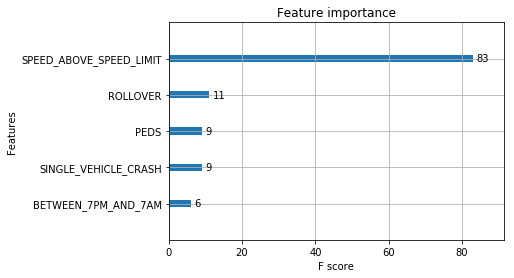

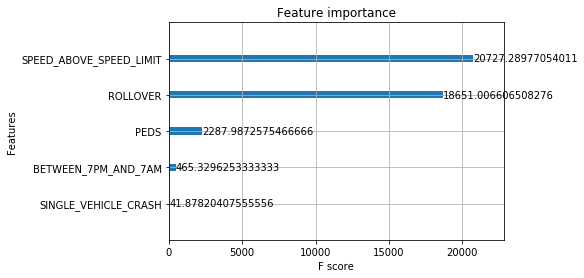

In [31]:
# see which features are most important
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [59]:
# convert probabilities in y_pred to classifications and get f1 scores for both train and test sets
def getAccuracyAndF1ScoreXGB(myModel, X_train, y_train, X_test, y_test, threshold=0.5):
    #print(cross_val_score(myModel, X_train_adjusted, y_train_adjusted, cv=10, scoring='f1').mean())
    y_train_pred = myModel.predict(X_train)
    y_test_pred = myModel.predict(X_test)
    train_predictions = []
    test_predictions = []
    for value in y_train_pred:
        if value >= threshold:
            train_predictions.append(1)
        else:
            train_predictions.append(0)
    for value in y_test_pred:
        if value >= threshold:
            test_predictions.append(1)
        else:
            test_predictions.append(0)
    #print(metrics.f1_score(y_train, train_predictions), metrics.accuracy_score(y_train, train_predictions))
    #print(metrics.f1_score(y_test, test_predictions), metrics.accuracy_score(y_test, test_predictions))
    return y_test_pred, metrics.f1_score(y_test, test_predictions)

In [61]:
# get list of f1 scores and accuracies with regards to different thresholds in order to graph them
thresholds, XGBScores, accuracy, allPredictions = [], [], [], []
for num in range(0,100,1):
    threshold = num/100
    XGBPred, XGBScore = getAccuracyAndF1ScoreXGB(fit_model, X_train, y_train, X_test, y_test, threshold)
    thresholds.append(threshold)
    XGBScores.append(XGBScore)
    test_predictions = []
    for value in XGBPred:
        if value >= threshold:
            test_predictions.append(1)
        else:
            test_predictions.append(0)
    accuracy.append(metrics.accuracy_score(y_test, test_predictions))
    allPredictions.append(test_predictions)

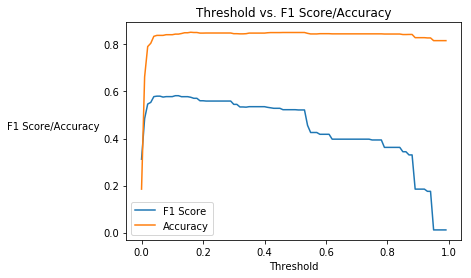

In [47]:
# graph f1 score, accuracies with regards to thresholds
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(thresholds, XGBScores, label='F1 Score')
ax.plot(thresholds, accuracy, label='Accuracy')

# naming the x axis 
plt.xlabel('Threshold') 
# naming the y axis 
h = plt.ylabel('F1 Score/Accuracy', labelpad=50) 
h.set_rotation(0)
# giving a title to my graph 
plt.title('Threshold vs. F1 Score/Accuracy') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 
#plt.savefig('threshold.png')

In [67]:
# find threshold with highest f1 score
bestThreshold = thresholds[XGBScores.index(max(XGBScores))]

# get binary predictions for total X matrix
y_pred = []
y_prob = fit_model.predict(X)
for value in y_prob:
    if value >= bestThreshold:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
# Compute nice confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
sn.heatmap(cnf_matrix, cmap='Blues', annot=True, fmt='g')